# Split quasar according to luminosity and redshift
More importantly, reweight them after the splitting.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.cosmology import Planck18 as cosmos
h = cosmos.H0.value/100
from astropy.io import fits
import healpy as hp
import seaborn as sns
from imsys_fitter import Syst
from sklearn.neighbors import BallTree

In [2]:
maps = fits.getdata('/uufs/chpc.utah.edu/common/home/astro/zheng/hd/data/SDSS_eBOSS_weight_maps/SDSSimageprop_Nside512.fits')
random_n = fits.getdata('/uufs/chpc.utah.edu/common/home/astro/zheng/hd/data/SDSS16Q/eBOSS_QSO_clustering_random-NGC-vDR16.fits')
random_s = fits.getdata('/uufs/chpc.utah.edu/common/home/astro/zheng/hd/data/SDSS16Q/eBOSS_QSO_clustering_random-SGC-vDR16.fits')
random_all = np.hstack((random_n, random_s))
quasar_n = fits.getdata('/uufs/chpc.utah.edu/common/home/astro/zheng/hd/data/SDSS16Q/eBOSS_QSO_clustering_data-NGC-vDR16.fits')
quasar_s = fits.getdata('/uufs/chpc.utah.edu/common/home/astro/zheng/hd/data/SDSS16Q/eBOSS_QSO_clustering_data-SGC-vDR16.fits')
quasar_SDSS = fits.getdata('/uufs/chpc.utah.edu/common/home/astro/zheng/hd/data/SDSS16Q/DR16Q_v4.fits')
tree = BallTree(data=np.deg2rad(np.c_[quasar_SDSS['DEC'], quasar_SDSS['RA']]),
                    leaf_size=5, metric='haversine')

In [3]:
# =====================================
# === copyed from reweighting.ipynb ===
# =====================================
Nside = 512
Npix = hp.nside2npix(Nside)
print(f'scale: {hp.nside2resol(Nside, True)} arcmin')

Rg = 3.793                                      # from 2002AJ....123..485S table 22

def get_property_map(ra, dec):
    pix = hp.ang2pix(Nside, np.deg2rad(90 - dec), np.deg2rad(ra))
    data = {}
    data['EBV'] = maps['EBV'][pix]
    data['DEPTH_G'] = 22.5 - 2.5*np.log10(maps['DEPTH_G'][pix]) - Rg*data['EBV']
    data['SKY_I'] = maps['SKY_I'][pix]
    data['PSF_I'] = maps['PSF_I'][pix]
    return data

def reweight(quasar_cata, random_cata):
    data_q = get_property_map(quasar_cata['RA'], quasar_cata['DEC'])
    data_r = get_property_map(random_cata['RA'], random_cata['DEC'])

    analyzer = Syst(quasar_cata['WEIGHT_FKP']*quasar_cata['WEIGHT_CP']*quasar_cata['WEIGHT_NOZ'], random_cata['WEIGHT_FKP'])
    for k in data_q.keys():
        analyzer.add_syst(k, data_q[k], data_r[k])
    analyzer.cut_outliers(p=1)
    analyzer.prepare()
    analyzer.fit_minuit()
    result = dict(zip(analyzer.par_names, analyzer.best_pars))
    weight_model = 1/analyzer.get_model(result, data_q)
    return weight_model

def refine_catalogue(quasar):
    quasar_cata = np.zeros(len(quasar), dtype=[('ra', 'f8'), ('dec', 'f8'), ('z', 'f8'), ('w', 'f8')])
    quasar_cata['ra'] = quasar['RA']
    quasar_cata['dec'] = quasar['DEC']
    quasar_cata['z'] = quasar['Z']
    quasar_cata['w'] = quasar['WEIGHT_SYSTOT']*quasar['WEIGHT_NOZ']*quasar['WEIGHT_CP']*quasar['WEIGHT_FKP']
    return quasar_cata

scale: 6.870972823634812 arcmin


Question: seperate luminosity from all quasars or from N/SGC? reweight the quasar from N/GC

Now I use quasar_n to split into two samples according to luminosity (quasar_n_high_L, quasar_n_low_L), reweight them and put them together to construct quasar_high_L, quasar_low_L. 

In [4]:
bins = np.linspace(0.8, 2.2, 30)            # the z cut applied to quasar lss all

def split_luminosity_and_reweight(quasar, random):
    """
    split the catalogue and reweight it seperately.
    """
    que = tree.query(np.deg2rad(np.c_[quasar['DEC'], quasar['RA']]))
    valid = que[0].flatten() < .5/3600*np.pi/180
    index = que[1].flatten()

    M_I = quasar_SDSS['M_I'][index]
    M_I[~valid] = np.nan
    result = np.digitize(quasar['Z'], bins)
    high = []
    low = []
    for i in range(1, 30):
        index = np.where(result == i)[0]
        M = M_I[index]
        middle = np.percentile(M[~np.isnan(M)], 50)
        high.append(index[M <= middle])
        low.append(index[M > middle])
    index_h = np.concatenate(high)
    index_l = np.concatenate(low)

    qh = quasar[index_h]
    ql = quasar[index_l]

    qh['WEIGHT_SYSTOT'] = reweight(qh, random)
    ql['WEIGHT_SYSTOT'] = reweight(ql, random)
    
    return refine_catalogue(ql), refine_catalogue(qh)

In [5]:
quasar_n_l, quasar_n_h = split_luminosity_and_reweight(quasar_n, random_n)
quasar_s_l, quasar_s_h = split_luminosity_and_reweight(quasar_s, random_s)

(0.0, 0, 0, 0, 0)
Maps available for chi2:
['EBV', 'DEPTH_G', 'SKY_I', 'PSF_I']
Fitting for:
['constant', 'EBV', 'DEPTH_G', 'SKY_I', 'PSF_I']
chi2 (before fit) = 92.92   ndata = 40                rchi2 = 2.3229
chi2 (after  fit) = 50.87   ndata = 40   npars = 5   rchi2 = 1.4534
(0.0, 0, 0, 0, 0)
Maps available for chi2:
['EBV', 'DEPTH_G', 'SKY_I', 'PSF_I']
Fitting for:
['constant', 'EBV', 'DEPTH_G', 'SKY_I', 'PSF_I']
chi2 (before fit) = 911.86   ndata = 40                rchi2 = 22.7964
chi2 (after  fit) = 47.77   ndata = 40   npars = 5   rchi2 = 1.3650
(0.0, 0, 0, 0, 0)
Maps available for chi2:
['EBV', 'DEPTH_G', 'SKY_I', 'PSF_I']
Fitting for:
['constant', 'EBV', 'DEPTH_G', 'SKY_I', 'PSF_I']
chi2 (before fit) = 98.73   ndata = 40                rchi2 = 2.4683
chi2 (after  fit) = 39.76   ndata = 40   npars = 5   rchi2 = 1.1360
(0.0, 0, 0, 0, 0)
Maps available for chi2:
['EBV', 'DEPTH_G', 'SKY_I', 'PSF_I']
Fitting for:
['constant', 'EBV', 'DEPTH_G', 'SKY_I', 'PSF_I']
chi2 (before fit) =

In [6]:
quasar_l = np.hstack((quasar_n_l, quasar_s_l))
quasar_h = np.hstack((quasar_n_h, quasar_s_h))

In [7]:
np.save('../catalogue/quasar_lss_high_L', quasar_h)
np.save('../catalogue/quasar_lss_low_L', quasar_l)

## testing part

In [11]:
def get_MI(quasar):
    que = tree.query(np.deg2rad(np.c_[quasar['dec'], quasar['ra']]))
    valid = que[0].flatten() < .5/3600*np.pi/180
    index = que[1].flatten()

    M_I = quasar_SDSS['M_I'][index]
    M_I[~valid] = np.nan

    return M_I

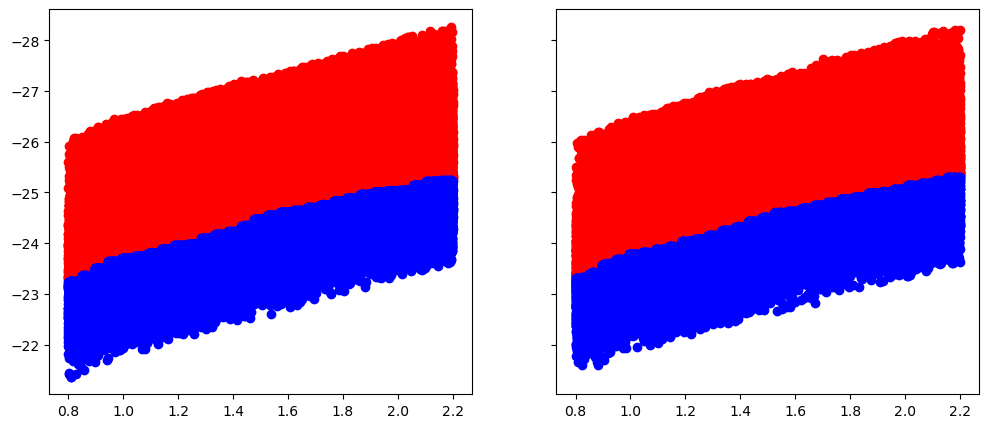

In [24]:
fig, ax = plt.subplots(1, 2, sharey=True, figsize=(12, 5))

ax[0].scatter(quasar_n_h['z'], get_MI(quasar_n_h), color='r')
ax[0].scatter(quasar_n_l['z'], get_MI(quasar_n_l), color='b')
ax[0].invert_yaxis()

ax[1].scatter(quasar_s_h['z'], get_MI(quasar_s_h), color='r')
ax[1].scatter(quasar_s_l['z'], get_MI(quasar_s_l), color='b')


In [4]:
def split_luminosity_and_reweight_test(quasar, random):
    """
    split the catalogue and reweight it seperately. for testing
    """
    que = tree.query(np.deg2rad(np.c_[quasar['DEC'], quasar['RA']]))
    valid = que[0].flatten() < .5/3600*np.pi/180
    index = que[1].flatten()

    M_I = quasar_SDSS['M_I'][index]
    M_I[~valid] = np.nan
    result = np.digitize(quasar['Z'], bins)
    high = []
    low = []
    for i in range(1, 30):
        index = np.where(result == i)[0]
        M = M_I[index]
        middle = np.percentile(M[~np.isnan(M)], 50)
        high.append(index[M <= middle])
        low.append(index[M > middle])
    index_h = np.concatenate(high)
    index_l = np.concatenate(low)

    qh = quasar[index_h]
    ql = quasar[index_l]

    wh = reweight(qh, random)
    wl = reweight(ql, random)

    return ((qh, wh), (ql, wl))

In [7]:
(qh, wh), (ql, wl) = split_luminosity_and_reweight_test(quasar_n, random_n)

(0.0, 0, 0, 0, 0)
Maps available for chi2:
['EBV', 'DEPTH_G', 'SKY_I', 'PSF_I']
Fitting for:
['constant', 'EBV', 'DEPTH_G', 'SKY_I', 'PSF_I']
chi2 (before fit) = 92.92   ndata = 40                rchi2 = 2.3229
chi2 (after  fit) = 50.87   ndata = 40   npars = 5   rchi2 = 1.4534
(0.0, 0, 0, 0, 0)
Maps available for chi2:
['EBV', 'DEPTH_G', 'SKY_I', 'PSF_I']
Fitting for:
['constant', 'EBV', 'DEPTH_G', 'SKY_I', 'PSF_I']
chi2 (before fit) = 911.86   ndata = 40                rchi2 = 22.7964
chi2 (after  fit) = 47.77   ndata = 40   npars = 5   rchi2 = 1.3650


In [8]:
norm = lambda a: a/np.mean(a)

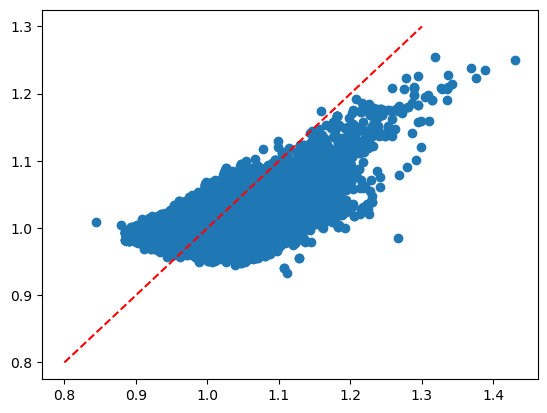

In [12]:
plt.scatter(norm(qh['WEIGHT_SYSTOT']), norm(wh))
plt.plot((0.8, 1.3), (0.8, 1.3), 'r--')

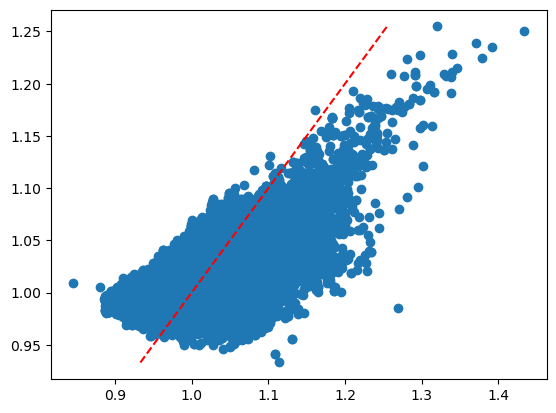

In [9]:
plt.scatter(qh['WEIGHT_SYSTOT'], wh)
plt.plot((wh.min(), wh.max()), (wh.min(), wh.max()), 'r--')

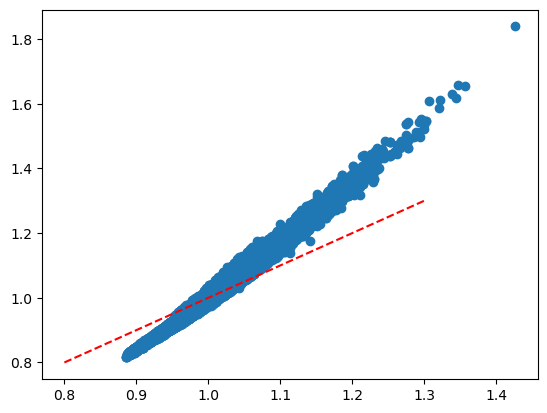

In [13]:
plt.scatter(norm(ql['WEIGHT_SYSTOT']), norm(wl))
plt.plot((0.8, 1.3), (0.8, 1.3), 'r--')

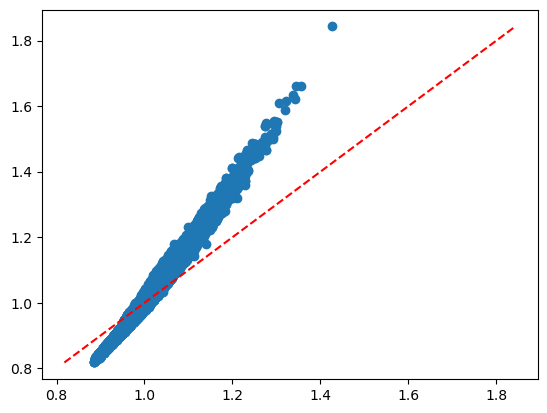

In [10]:
plt.scatter(ql['WEIGHT_SYSTOT'], wl)
plt.plot((wl.min(), wl.max()), (wl.min(), wl.max()), 'r--')